In [79]:
# Importando arquivo de funcoes

import sys  
sys.path.insert(0, './funcoesTermosol.py')

import funcoesTermosol
import numpy as np

In [104]:
# Funcoes suporte

def getL(p1, p2):
    return np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)

def getK(E, A, p1, p2):
    
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    L = getL(p1,p2)
    
    s = (y2 - y1)/L
    c = (x2 - x1)/L
    
    K = np.array([
        [c**2, c*s, -c**2, -c*s],
        [c*s, s**2, -c*s, -s**2],
        [-c**2, -c*s, c**2, c*s],
        [-c*s, -s**2, c*s, s**2]
    ])
    
    return K*(E*A/L)

# GDP corresponde a 2x - 2 para X e 2x - 1 para Y.
# Ex. Nó 1. GDL: em X --> 0, em Y --> 1
# Ex. Nó 2. GDL: em X --> 2, em Y --> 3
# Ex. Nó 3. GDL: em X --> 4, em Y --> 5

def getGDLx(no):
    return 2*no - 2

def getGDLy(no):
    return 2*no - 1

# Matriz para passar do k do elemento para o global
def k_elemento_2_global(k_e, lista_indexes, k_global):

    for i in range(4):
        for j in range(4):
            k_global[lista_indexes[i]][lista_indexes[j]] += k_e[i][j]
        
    return k_global

def getSinCos(p1, p2):
    
    x1 = p1[0]
    y1 = p1[1]
    
    x2 = p2[0]
    y2 = p2[1]
    
    L = getL(p1,p2)
    
    s = (y2 - y1)/L
    c = (x2 - x1)/L
    
    return s,c

In [81]:
# Gera K global
def get_k_global(numero_de_nos, numero_de_membros, props_membros, nos, restricoes):

    k_global = np.zeros((numero_de_nos*2, numero_de_nos*2))
    
    # Loop principal
    for n in range(numero_de_membros):

        # Define valores do nós de análise
        no1 = int(props_membros[n][0])
        no2 = int(props_membros[n][1])

        # Gera a lista de GDP para cada elemento
        GDL_indexes = [getGDLx(no1), getGDLy(no1), getGDLx(no2), getGDLy(no2)]

        # Destrincha E e A do input
        E = props_membros[n][2]
        A = props_membros[n][3]

        # Destrincha os nós 1 e 2 de cada elemento (ajuste de index)
        p_no1 = (nos[0][no1 - 1], nos[1][no1 - 1])
        p_no2 = (nos[0][no2 - 1], nos[1][no2 - 1])

        # Gera a matriz K do elemento ja com o calculo de E*A/L
        K_elemento = getK(E, A, p_no1, p_no2)

        # Gera a matriz global
        k_global = k_elemento_2_global(K_elemento, GDL_indexes, k_global)


    # Pega a matriz global e cortar as linhas e colunas com restrição
    k_global_limpa = k_global
    for i in np.flip(restricoes):
        r = int(i[0])
        k_global_limpa = np.delete(k_global_limpa, r, 0)
        k_global_limpa = np.delete(k_global_limpa, r, 1)
        
    return k_global, k_global_limpa


In [82]:
# Limpa a matriz de forcas
def get_forcas_nos(forcas_nos, restricoes):
    
    # Cortando restrições da matriz global de forças
    for i in np.flip(restricoes):
        r = int(i[0])
        forcas_nos = np.delete(forcas_nos, r, 0)

    return forcas_nos

In [83]:
# Encontra reacoes
def get_reacoes(u, restricoes, numero_de_nos, k_global):
    
    u_completo = []
    lista_restricoes = []
    for r in restricoes:
        lista_restricoes.append(int(r[0]))
    
    contador = 0
    for i in range(numero_de_nos*2):
        
        if i in lista_restricoes:
            u_completo.append(0)
            
        else:
            u_completo.append(u[contador][0])
            contador += 1
    
    u_completo = np.array(u_completo)
    
    reacoes = np.dot(k_global, u_completo.T)
    
    lista_de_reacoes = []
    for r in lista_restricoes:
        lista_de_reacoes.append(reacoes[r])

    return np.array(lista_de_reacoes), u_completo
    

In [141]:
# Encontra deformacoes
def get_deformacoes(numero_de_nos, numero_de_membros, nos, deslocamentos, props_membros):
    
    deformacoes = []
    
    for n in range(numero_de_membros):

        # Define valores do nós de análise
        no1 = int(props_membros[n][0])
        no2 = int(props_membros[n][1])
        
        # Puxando pontos cartesianos do nós
        p_no1 = (nos[0][no1 - 1], nos[1][no1 - 1])
        p_no2 = (nos[0][no2 - 1], nos[1][no2 - 1])
        
        # Encontrando seno e cosseno
        s,c = getSinCos(p_no1, p_no2)
        
        # Encontrando distancia entre os nós
        L = getL(p_no1, p_no2)
        
        # Puxando deslocamentos por nó
        d_no1x = deslocamentos[2*no1-2]
        d_no1y = deslocamentos[2*no1-1]
        
        d_no2x = deslocamentos[2*no2-2]
        d_no2y = deslocamentos[2*no2-1]
        
        # Montando matrizes
        vetor_s_c = [[-c, -s, c, s]]
        vetor_desloc = [[d_no1x],[d_no1y],[d_no2x],[d_no2y]]
        
        # Gerando resultado
        deform = np.matmul(vetor_s_c, vetor_desloc) * (1/L)
        
        deformacoes.append(deform[0][0])
    
    return np.array(deformacoes)
        

In [142]:
# Encontra tensoes
def get_tensoes(numero_de_membros, deformacoes, props_membros):
    
    lista_de_tensoes = []
    for i in range(numero_de_membros):
        E = props_membros[i][2]
        deform = deformacoes[i]
        lista_de_tensoes.append(E * deform)
        
    return np.array(lista_de_tensoes)

In [143]:
# Encontra forcas internas
def get_forca_interna(numero_de_membros, props_membros, tensoes_internas):
    
    lista_de_forcas = []
    for i in range(numero_de_membros):
        A = props_membros[i][3]
        sigma = tensoes_internas[i]
        lista_de_forcas.append(A * sigma)
    
    return np.array(lista_de_forcas)

In [144]:
# Solver por Gauss
def solver_gauss(ite, tol, n, K, F, printResult=True):
    U = np.zeros((n, 1))
    U_before = np.zeros((n, 1))
    errors = np.ones((n, 1))
    
    count = 0
    while (count < ite):
        for i in range(n):
            U_before[i] = U[i] # realocando os valores de U para uma nova iteração
        for i in range(n):
            numerator = 0
            for j in range(n):
                if (j != i): # não queremos os valores da diagonal principal
                    numerator -= K[i][j]*U[j]    
            U[i] = (F[i]+numerator)/K[i][i]
            errors[i] = abs((U[i] - U_before[i])/U[i]) # os valores de erro para da componente do vetor de deslocamento 
                                                       # são adicionados em uma matriz de erro de dimensão nx1
        # pegamos o valor máximo dessa matriz
        error = np.amax(errors)
        count+=1
        
        # comparamos seu valor com a tolerância
        if error <= tol :
            if printResult:
                print('Convergência atingida !')
                print('vetor U: ')
                print('----------------------')
                #print(U)
            return U
            
    return 'Não convergiu'

In [145]:
# Funcao que ajusta prints
def ajusta_print(lista):
    
    nova_lista = []
    for i in lista:
        nova_lista.append([i])
        
    return np.array(nova_lista)

In [146]:
def plota(N,Inc,title,forcas=[], hasGrid=True):
    # Numero de membros
    nm = len(Inc[:,0])
    
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(15,10))
    # Passa por todos os membros
    for i in range(nm):
        
        # encontra no inicial [n1] e final [n2] 
        n1 = int(Inc[i,0])
        n2 = int(Inc[i,1])        

        plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]],color='r',linewidth=3)
    
    if len(forcas) != 0:
        for i in range(len(forcas)):
            if forcas[i] != 0:
                plt.plot(N[0][i//2], N[1,i//2], "ko")
                if forcas[i] < 0:
                    l = 0.05*forcas[i][0]/1000
                    if i % 2 == 0:
                        plt.arrow(N[0][i//2] - l, N[1,i//2], l+0.01, 0, width=0.004, length_includes_head=True, color="black")
                        plt.text(N[0][i//2] - l + 0.01, N[1,i//2], str(-1*int(forcas[i][0])), bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))
                    else:
                        plt.arrow(N[0][i//2], N[1,i//2] - l, 0, l+0.01, width=0.004, length_includes_head=True, color="black")
                        plt.text(N[0][i//2], N[1,i//2] - l + 0.01, str(-1*int(forcas[i][0])), bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))
    
    plt.title(title)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.grid(hasGrid)
    plt.axis('equal')
    plt.show()

In [147]:
def plota_comparacoes(N,Ndef,Inc,title):
    # Numero de membros
    nm = len(Inc[:,0])
    
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(15,10))
    # Passa por todos os membros
    boolSemDef = False
    for i in range(nm):
        
        # encontra no inicial [n1] e final [n2] 
        n1 = int(Inc[i,0])
        n2 = int(Inc[i,1])        
        
        if not boolSemDef:
            plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]],color='r',linewidth=2, alpha=0.5, label="Sem deformação")
        else:
            plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]],color='r',linewidth=2, alpha=0.5)

        boolSemDef = True
    
    boolComDef = False
    for i in range(nm):
        
        # encontra no inicial [n1] e final [n2] 
        n1 = int(Inc[i,0])
        n2 = int(Inc[i,1])        

        if not boolComDef:
            plt.plot([Ndef[0,n1-1],Ndef[0,n2-1]],[Ndef[1,n1-1],Ndef[1,n2-1]],color='b',linewidth=2, alpha=0.5, label="Com deformação")
        else:
            plt.plot([Ndef[0,n1-1],Ndef[0,n2-1]],[Ndef[1,n1-1],Ndef[1,n2-1]],color='b',linewidth=2, alpha=0.5)

        boolComDef = True
    
    plt.title(title)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [150]:
# Funcao principal
def main():
    
    # Importando dados
    numero_de_nos, nos, numero_de_membros, props_membros, numero_de_cargas, forcas_nos, numero_de_apoios, restricoes = funcoesTermosol.importa('./entrada2.xls')
    
    # Plot visual
    plota(nos, props_membros, "Ilustração sem deformação")
    plota(nos, props_membros, "Ilustração sem deformação com marcação de forças", forcas_nos, False)

    # Parametros do solver
    iteracoes = 10000
    tolerancia = 1e-10
    n = numero_de_nos*2 - len(restricoes)
    
    # Definindo matrizes de k global e forcas
    k_global, k_global_limpa = get_k_global(numero_de_nos, numero_de_membros, props_membros, nos, restricoes)
    forcas_nos = get_forcas_nos(forcas_nos, restricoes)
    
    # Aplicando solver 
    u = solver_gauss(iteracoes, tolerancia, n, k_global_limpa, forcas_nos, False)
    
    # Encontrando reacoes de apoio e deslocamentos
    reacoes_de_apoio, deslocamentos = get_reacoes(u, restricoes, numero_de_nos, k_global)

    # Encontrando deformacoes
    deformacoes = get_deformacoes(numero_de_nos, numero_de_membros, nos, deslocamentos, props_membros)

    # Encontrando tensoes internas
    tensoes_internas = get_tensoes(numero_de_membros, deformacoes, props_membros)
    
    # Encontrando forcas internas
    forcas_internas = get_forca_interna(numero_de_membros, props_membros, tensoes_internas)
    
    # Ajustando listas para printar do jeito correto
    reacoes_de_apoio = ajusta_print(reacoes_de_apoio)
    deslocamentos = ajusta_print(deslocamentos)
    deformacoes = ajusta_print(deformacoes)
    tensoes_internas = ajusta_print(tensoes_internas)
    forcas_internas = ajusta_print(forcas_internas)
    
    # Gerando saida
    funcoesTermosol.geraSaida("Result", reacoes_de_apoio, deslocamentos, deformacoes, forcas_internas, tensoes_internas)

    return 
     

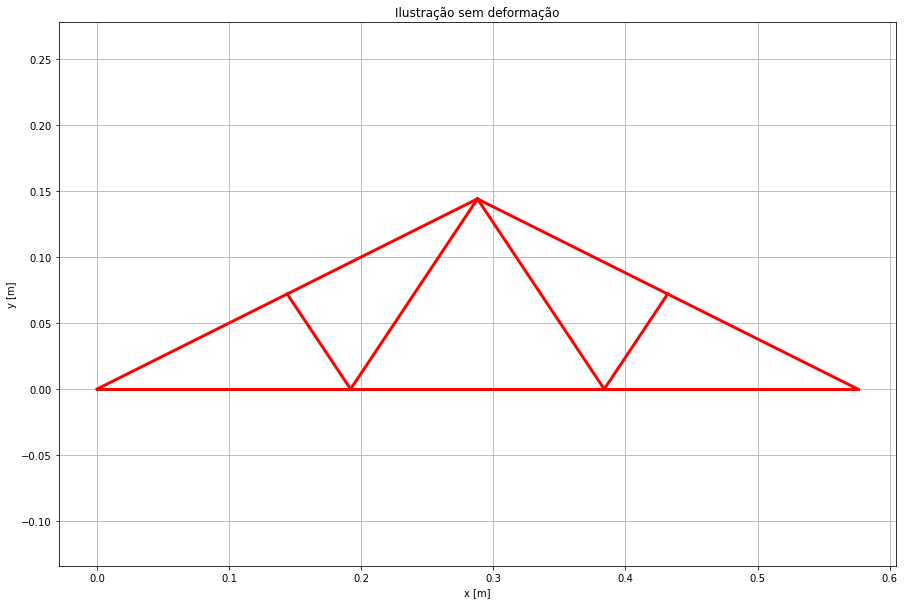

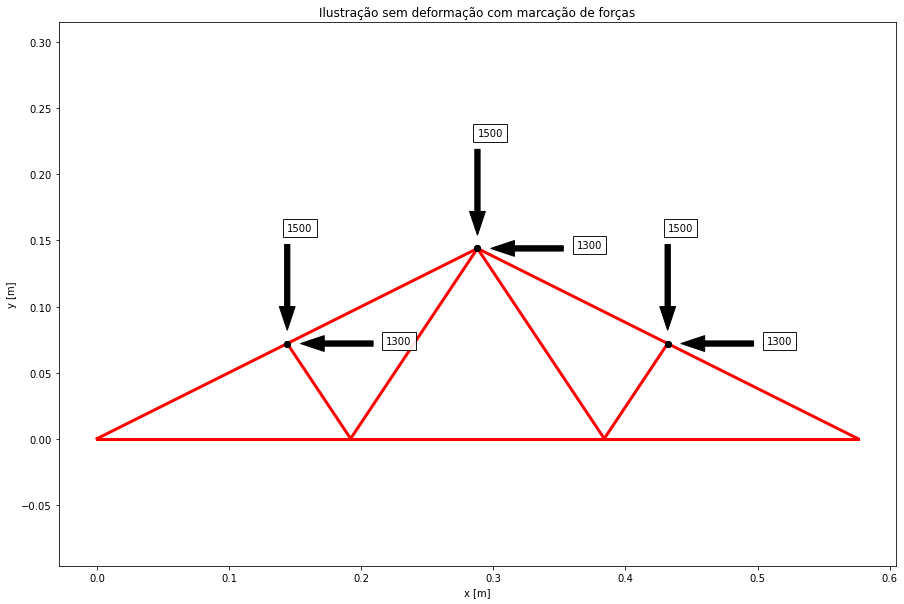

In [151]:
main()